# Library

In [22]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import pickle
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# LightGBM

In [2]:
df = pd.read_parquet('../ResultsBERTopic/BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout.parquet')
df.head()

,Document,Embedding,Topic,Probability,Created_on,Count,Name,Representation,Representative_Docs,UMAP_embedding
0,checks,"[0.052164897, 0.029597273, -0.03666609, 0.0051...",4,0.000000,2020-01-09,6299,4_mdma_lsd_get_looking,"[mdma, lsd, get, looking, wsm, good, btc, ques...","[hey ro im gon na pull pk, life wonderful life...","[1.6488198, 9.914265, 1.442794, 2.8094368, -0...."
1,trusted vendor status,"[0.02445144, -0.008732641, -0.0050215074, 0.01...",2,0.944247,2020-01-09,6907,2_vendor_scammer_scam_looking,"[vendor, scammer, scam, looking, scamming, sal...","[looking good reliable vendor sell ounce, vend...","[2.910516, 10.281041, 1.650234, 3.0320778, -0...."
2,empire exit scam iiflux user incomming,"[0.02890829, 0.036081452, -0.027694924, -0.007...",1,1.000000,2019-11-06,6236,1_market_empire_dream_nightmare,"[market, empire, dream, nightmare, vendor, dre...","[next market, dream market vendor rstclass nig...","[1.5884036, 9.8587885, 3.3090453, 2.652358, 2...."
3,ecstasy vendor packs,"[-0.022524439, 0.03949761, -0.023750877, 0.033...",5,0.797741,2020-01-09,2776,5_order_package_shipping_delivery,"[order, package, shipping, delivery, pack, shi...",[order accepted day still hasnt marked shipped...,"[2.0245404, 10.517631, 2.3443217, 3.7595236, -..."
4,opening bank account person fake id,"[-0.029834118, 0.03354508, -0.012210185, -0.02...",6,1.000000,2019-11-06,2823,6_bitcoin_card_wallet_btc,"[bitcoin, card, wallet, btc, bank, credit, car...","[credit cards paypal prepaid card find, got cc...","[0.7278271, 9.884823, 1.8116106, 2.9336705, -0..."


In [3]:
df = df[['Topic', 'Embedding']]
df['Topic'] = df['Topic'].astype(int)

In [4]:
embedding_dim = len(df['Embedding'][0])
embedding_cols = pd.DataFrame(df['Embedding'].tolist(), index=df.index, columns=[f'embedding_{i}' for i in range(embedding_dim)])
df = pd.concat([df, embedding_cols], axis=1)

In [34]:
X = df.drop(columns=['Topic', 'Embedding'])
y = df["Topic"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [35]:
X_train.shape, X_valid.shape, X_test.shape

((26541, 512), (5687, 512), (5688, 512))

## Training

In [62]:
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique()),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': 8,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

eval_result = {}
bst = lgb.train(params,
                train_data,
                valid_sets=[train_data, valid_data],
                num_boost_round=30,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=3),
                    lgb.log_evaluation(period=10),
                    lgb.record_evaluation(eval_result)
                ])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 26541, number of used features: 512
[LightGBM] [Info] Start training from score -1.498835
[LightGBM] [Info] Start training from score -1.787811
[LightGBM] [Info] Start training from score -1.699300
[LightGBM] [Info] Start training from score -2.197903
[LightGBM] [Info] Start training from score -1.792325
[LightGBM] [Info] Start training from score -2.594080
[LightGBM] [Info] Start training from score -2.601673
Training until validation scores don't improve for 3 rounds
[10]	training's multi_logloss: 0.539933	valid_1's multi_logloss: 0.585397
[20]	training's multi_logloss: 0.269536	valid_1's multi_logloss: 0.332143
[30]	training's multi_logloss: 0.162262	valid_1's multi_logloss: 0.239565
Did not meet early stopping. Best iteration is:


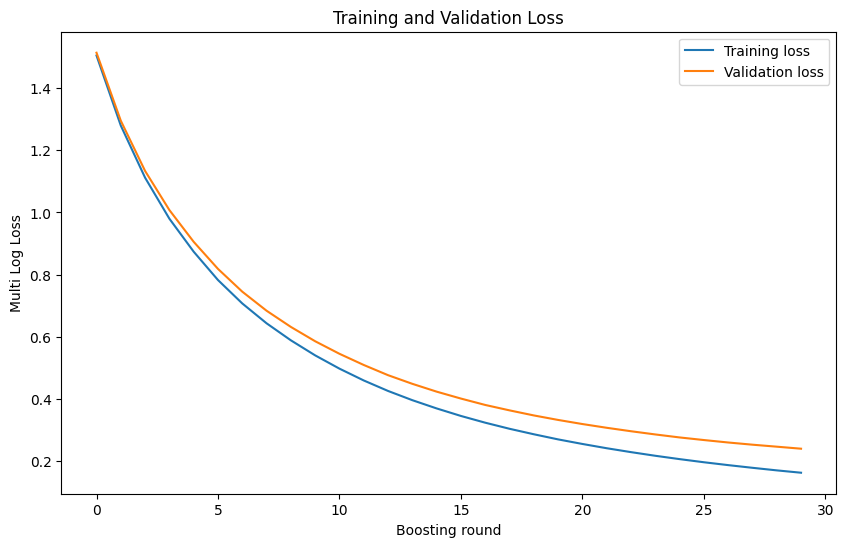

In [63]:
train_losses = eval_result['training']['multi_logloss']
valid_losses = eval_result['valid_1']['multi_logloss']

# Plot delle loss durante l'addestramento
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Boosting round')
plt.ylabel('Multi Log Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluation

In [64]:
y_pred = bst.predict(X_test)
y_pred_max = [np.argmax(line) for line in y_pred]
print(f"Classification Report on Test Set:\n\n{classification_report(y_test, y_pred_max)}")

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1398
           1       0.94      0.95      0.94       871
           2       0.91      0.91      0.91      1005
           3       0.98      0.96      0.97       619
           4       0.93      0.95      0.94       953
           5       0.94      0.91      0.92       407
           6       0.95      0.90      0.93       435

    accuracy                           0.93      5688
   macro avg       0.94      0.93      0.93      5688
weighted avg       0.93      0.93      0.93      5688



In [65]:
y_pred = bst.predict(X_valid)
y_pred_max_valid = [np.argmax(line) for line in y_pred]
print(f"Classification Report on Validation Set:\n\n{classification_report(y_valid, y_pred_max_valid)}")

Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1318
           1       0.94      0.93      0.94       924
           2       0.92      0.92      0.92      1050
           3       0.98      0.96      0.97       664
           4       0.92      0.94      0.93       925
           5       0.92      0.86      0.89       386
           6       0.93      0.89      0.91       420

    accuracy                           0.93      5687
   macro avg       0.93      0.92      0.93      5687
weighted avg       0.93      0.93      0.93      5687



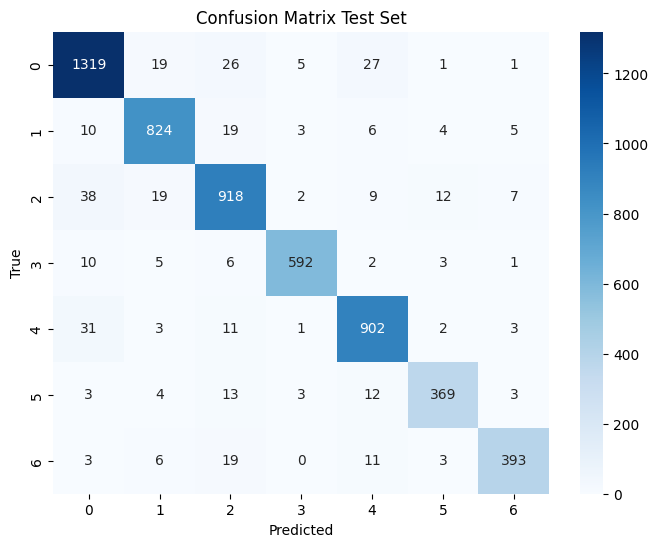

In [66]:
cm = confusion_matrix(y_test, y_pred_max)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Test Set')
plt.show()

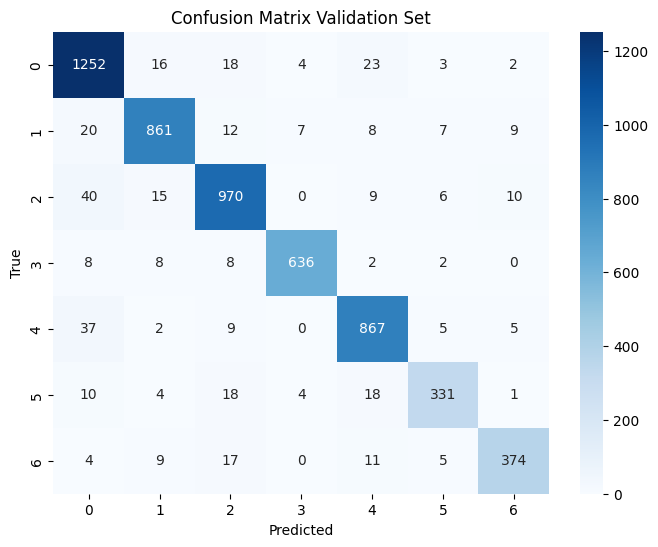

In [67]:
cm = confusion_matrix(y_valid, y_pred_max_valid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Validation Set')
plt.show()

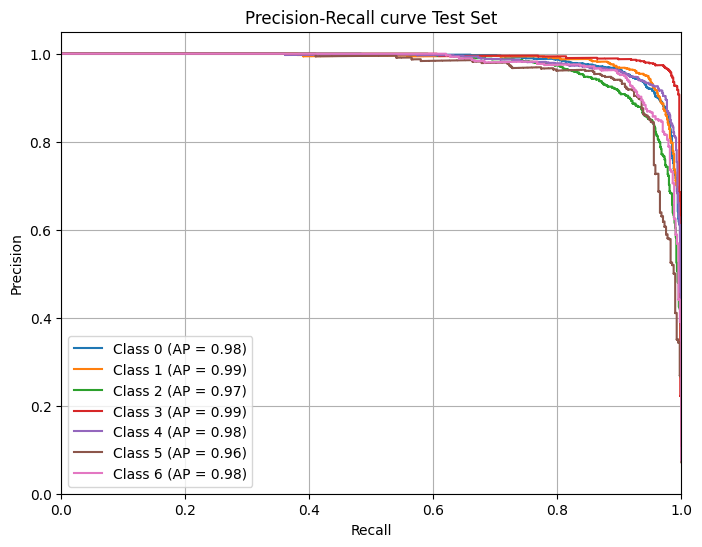

In [68]:
classes = np.unique(y)
y_test_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_test_bin = label_binarize(y_test, classes=classes)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_test_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_test_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.step(recall[i], precision[i], where='post', label=f'Class {classes[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve Test Set')
plt.legend(loc='best')
plt.grid(True)
plt.show()

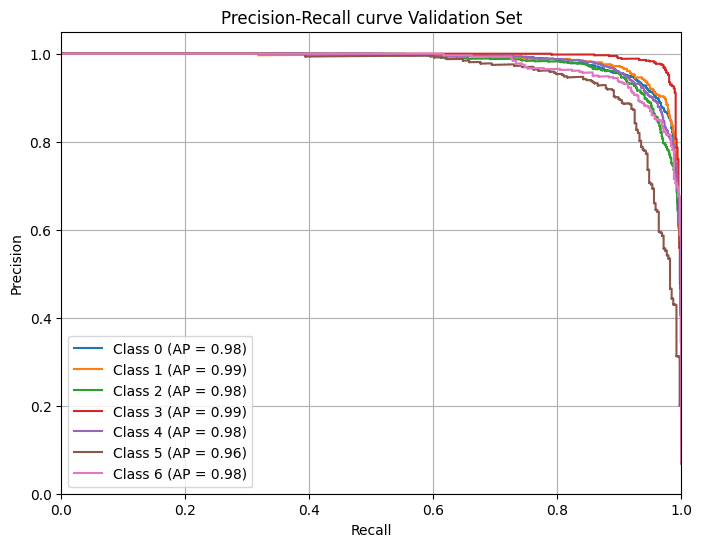

In [69]:
classes = np.unique(y)
y_valid_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)
y_valid_bin = label_binarize(y_valid, classes=classes)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_valid_bin[:, i], y_valid_pred[:, i])
    average_precision[i] = average_precision_score(y_valid_bin[:, i], y_valid_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.step(recall[i], precision[i], where='post', label=f'Class {classes[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve Validation Set')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Save Model

In [70]:
with open('model.pkl', 'wb') as f:
    pickle.dump(bst, f)

In [71]:
bst.save_model('model.txt')

## Predict Example